In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import cv2
from random import shuffle

from sklearn import linear_model, metrics
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


C:\Users\JChaotogo\Anaconda\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


In [2]:
normal_train = r'C:\Users\JChaotogo\Documents\DataSets\chest_xray\train\NORMAL'
pneumonia_train = r'C:\Users\JChaotogo\Documents\DataSets\chest_xray\train\PNEUMONIA'

In [3]:
def create_train():
    normal_data=[]
    pneumonia_data=[]
    for img in tqdm(os.listdir(normal_train)):
        path = os.path.join(normal_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        normal_data.append(np.array(img))
    for img in tqdm(os.listdir(pneumonia_train)):
        path = os.path.join(pneumonia_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        pneumonia_data.append(np.array(img))
    training_data = normal_data + pneumonia_data
    np.save('train_datanew.npy', training_data)
    return training_data
        

In [4]:
#train_data = create_train()
train_data = create_train()

100%|██████████| 3875/3875 [03:20<00:00, 19.35it/s]


In [5]:
train_data = np.array(train_data)

In [6]:
newneg = [0]*1341
poslab = [1]*3875
labs = newneg + poslab
labs = np.array(labs)

negativelabels = [0] *1341
positivelabels = [1] *3875
labels = negativelabels + positivelabels
labels = np.array(labels)
labels.shape

zipped = list(zip(train_data, labels))
shuffle(zipped)
train_data, labels = zip(*zipped)
labels

In [5]:
#np.save('train_data.npy', train_data)
#np.save('labels.npy', labels)

NameError: name 'train_data' is not defined

In [6]:
#train_data = np.load('train_data.npy')
#labels = np.load('labels.npy')

In [22]:
#X = train_data.reshape(5216)
X = train_data
Y = labs
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3)

In [9]:
X.shape

(5216, 28, 28)

In [10]:
X = X.reshape(5216,28*28)
Y = labs
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=.3)

In [11]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(lr.score(X_train,y_train))
print(lr.score(X_test, y_test))
predlr = lr.predict(X_test)
print('Cross-Tab\n\n',pd.crosstab(predlr, y_test))
print('\nClassification Report\n\n', classification_report(y_test, predlr))
print(cross_val_score(lr, X, Y, cv=5, n_jobs=-1))

C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9835661462612982
0.9533546325878595
Cross-Tab

 col_0    0     1
row_0           
0      344    37
1       36  1148

Classification Report

               precision    recall  f1-score   support

           0       0.90      0.91      0.90       380
           1       0.97      0.97      0.97      1185

   micro avg       0.95      0.95      0.95      1565
   macro avg       0.94      0.94      0.94      1565
weighted avg       0.95      0.95      0.95      1565

[0.9454023  0.95206136 0.96452541 0.96260786 0.95589645]


In [16]:
rbm = BernoulliRBM(verbose=True, n_components=100)
rbmpipeline = Pipeline(steps=[('rbm', rbm), ('lr', lr)])
rbmpipeline.fit(X_train, y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -523.76, time = 0.35s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -512.85, time = 0.45s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -509.68, time = 0.42s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -494.45, time = 0.39s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -493.70, time = 0.45s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -496.08, time = 0.41s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -510.73, time = 0.39s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -511.11, time = 0.50s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -530.82, time = 0.40s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -509.94, time = 0.40s


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('rbm', BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=100, n_iter=10,
       random_state=None, verbose=True)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [17]:
print(rbmpipeline.score(X_train, y_train))
print(rbmpipeline.score(X_test, y_test))
rbmpredict = rbmpipeline.predict(X_test)
print(pd.crosstab(rbmpredict, y_test))
print(classification_report(y_test, rbmpredict))

0.7367844426184607
0.7571884984025559
col_0    0     1
row_0           
1      380  1185


C:\Users\JChaotogo\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       380
           1       0.76      1.00      0.86      1185

   micro avg       0.76      0.76      0.76      1565
   macro avg       0.38      0.50      0.43      1565
weighted avg       0.57      0.76      0.65      1565



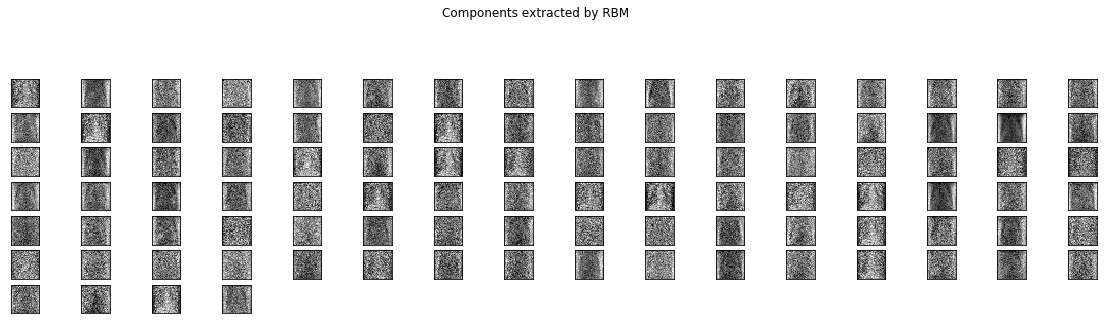

In [18]:
plt.figure(figsize=(20,10))

for i, component in enumerate(rbm.components_):
    plt.subplot(16,16,i+1)
    plt.imshow(component.reshape((28, 28)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Components extracted by RBM')
plt.show()

[BernoulliRBM] Iteration 1, pseudo-likelihood = -526.61, time = 0.33s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -518.88, time = 0.41s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -521.75, time = 0.45s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -510.91, time = 0.45s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -494.79, time = 0.54s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -504.04, time = 0.50s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -500.31, time = 0.46s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -505.22, time = 0.39s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -503.68, time = 0.41s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -475.64, time = 0.49s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -479.03, time = 0.57s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -487.27, time = 0.49s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -474.99, time = 0.51s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -486.49, time = 0.50s
[BernoulliRBM] 

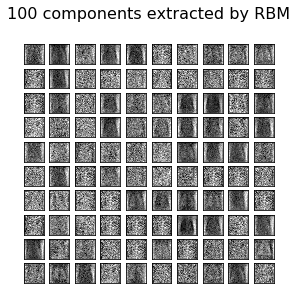

In [20]:
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# Training
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)

# Evaluation
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

# Plotting
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

In [60]:
#Create more data by nudging 1 pixel
def nudge_dataset(X, Y):
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    def shift(x, w):
        return convolve(x.reshape((28,28)), weights=w, mode='constant').ravel()

    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [62]:
X = X.reshape(5216,28*28)
Y = labs
print(X.shape)
X,Y = nudge_dataset(X,Y)

(5216, 784)


In [63]:
Y.shape

(26080,)

In [65]:
X.shape

(26080, 784)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.3)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -453.54, time = 2.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -459.32, time = 2.04s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -452.06, time = 2.15s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -453.05, time = 2.05s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -442.10, time = 1.96s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -448.85, time = 2.06s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -440.35, time = 2.02s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -445.97, time = 2.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -447.83, time = 2.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -439.47, time = 1.96s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -458.23, time = 1.98s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -438.55, time = 1.99s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -446.28, time = 2.03s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -443.08, time = 2.16s
[BernoulliRBM] 

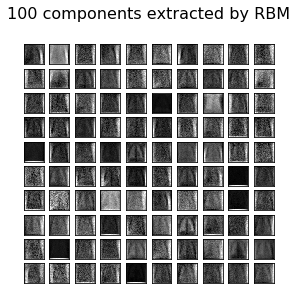

In [67]:
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# Training
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)

# Evaluation
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

# Plotting
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Addressing Class imbalance

Here I resample the pneumonia class to be equal to the normal class.

In [74]:
def create_trainUS():
    normal_data=[]
    pneumonia_data=[]
    for img in tqdm(os.listdir(normal_train)):
        path = os.path.join(normal_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        normal_data.append(np.array(img))
    for img in tqdm(os.listdir(pneumonia_train)):
        path = os.path.join(pneumonia_train, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (28,28))
        img = img.astype(np.float32)/255.
        pneumonia_data.append(np.array(img))
    shuffle(pneumonia_data)
    training_data = normal_data + pneumonia_data[0:1341]
    np.save('train_dataUS.npy', training_data)
    return training_data
        

In [77]:
training_Data = create_trainUS()

100%|██████████| 3875/3875 [00:22<00:00, 175.83it/s]


In [93]:
training_data = np.array(training_Data)
training_data = training_data.reshape(2682, 28*28)

USlabels = [0] *1341 + [1] *1341
Y = np.array(USlabels)

X = training_data
X, Y = nudge_dataset(X,Y)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.3)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -447.98, time = 0.95s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -438.70, time = 1.22s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -426.71, time = 0.98s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -435.96, time = 0.96s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -448.65, time = 0.99s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -443.57, time = 1.11s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -452.41, time = 0.98s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -433.71, time = 1.06s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -431.60, time = 1.06s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -435.96, time = 1.00s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -440.62, time = 0.99s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -440.99, time = 1.29s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -442.85, time = 1.00s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -439.45, time = 0.96s
[BernoulliRBM] 

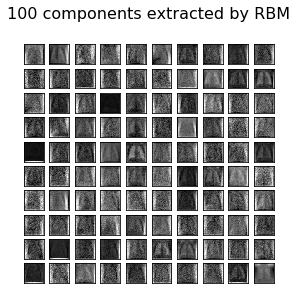

In [98]:
logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000,
                                           multi_class='multinomial')
rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('logistic', logistic)])

# Training
rbm.learning_rate = 0.06
rbm.n_iter = 20
rbm.n_components = 100
logistic.C = 6000

# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, y_train)

raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.
raw_pixel_classifier.fit(X_train, y_train)

# Evaluation
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n" % (
    metrics.classification_report(y_test, Y_pred)))

# Plotting
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

# Conclusion
Overall Logistic regression on the raw image files outperformed the RBM extracted images. Further tweaking of the RBM parameters such as increasing n_components may increase performance.

There was a class imbalance ~ 3:1 pneunomia:normal that caused logistic regression on RBM features to only predict pneumonia. After correcting for the class imbalance by creating a random sample of pneumonia images the same length as normal images we saw a more accurate prediction. RBM features still performed worse than the raw image files (82% recall and precision vs 91%/93% precision/recall of raw images). 

Shifting the images to artificially create new training data is also a questionable practice. The shifted images should be the same as the original images and be weighted equally which should lead to the same performance, but instead we saw a significant increase in performance.

Another factor to consider is the effect that image size may have on performance. a 28x28 image shifted 1 pixel will have a much greater difference than a 100x100 image shifted 1 pixel. Further exploration of image size should also be explored.